In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [16]:
import glob
import os
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
import xgboost

import keras
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import pandas as pd
from nltk.stem.porter import PorterStemmer
import re
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

parser = English()
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


In [17]:
spacy.load('en_core_web_sm')

In [18]:
import requests
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
r = requests.get(url)
with open('aclImdb_v1.tar.gz', 'wb') as f:
    f.write(r.content)

In [19]:
import tarfile
tar = tarfile.open('aclImdb_v1.tar.gz', 'r:gz')
tar.extractall()
tar.close()


In [20]:
import pandas as pd
import os
def load_data(root):
    data = []
    filenames = ['neg', 'pos']
    for sentiment in filenames:
        sentiment_dir = os.path.join(root, sentiment)
        for filename in os.listdir(sentiment_dir):
            with open(os.path.join(sentiment_dir, filename), 'r') as f:
                review = f.read()
                data.append((review, sentiment))
    return pd.DataFrame(data, columns=['review', 'sentiment'])

train_data = load_data('aclImdb/train')
test_data=load_data('aclImdb/test')

In [21]:
train_data

review sentiment
0      Unwatchable. You can't even make it past the f...       neg
1      ...for this movie defines a new low in Bollywo...       neg
2      Watching CBS's "Surrender, Dorothy", I kept wo...       neg
3      "Everything a great documentary could be"?? Ye...       neg
4      I was skimming over the list of films of Richa...       neg
...                                                  ...       ...
24995  Last year we were treated to two movies about ...       pos
24996  Dick Clement and Ian La Frenais have a solid h...       pos
24997  I saw this film in Winnipeg recently - appropr...       pos
24998  My watch came a little too late but am glad i ...       pos
24999  this is best showing of what i think jesus rea...       pos

[25000 rows x 2 columns]

In [22]:
test_data

review sentiment
0      Let me first state that I rarely review movies...       neg
1      I went to see this 3 nights ago here in Cork, ...       neg
2      I would think that this was one of those films...       neg
3      Forgive me, but this work of director Peter Ha...       neg
4      "Fat Girls" is among the worst films within th...       neg
...                                                  ...       ...
24995  This is how I interpreted the movie: First thi...       pos
24996  This is first of all a good, exciting story, w...       pos
24997  The first, and far better, of Kevin Kline's tw...       pos
24998  Xavier,a French student moves into an apartmen...       pos
24999  i see there are great reviews of this film alr...       pos

[25000 rows x 2 columns]

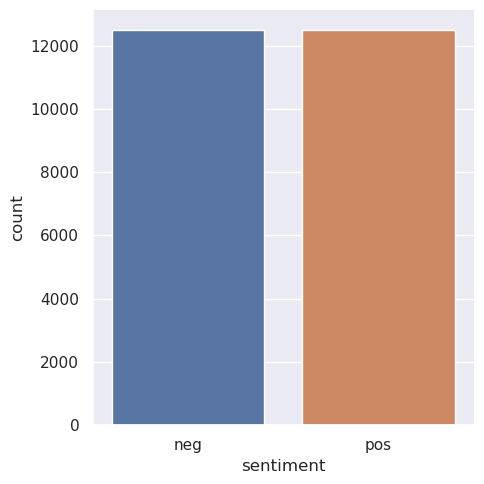

In [9]:
sns.set(rc={'figure.figsize':(10,10)})
sns.catplot(data=train_data, x='sentiment', kind='count')

In [8]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pritts35/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# stop words and spcecial characters 
# STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
# SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

# # Data Cleaner and tokenizer
# def tokenizeText(text):
#     # stop words and spcecial characters 
#     STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
#     SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]
#     SYMBOLS = set(" ".join(string.punctuation).split())

    
#     text = text.strip().replace("\n", " ").replace("\r", " ")
#     text = text.lower()
#     print (text)
    
#     tokens = parser(text)
#     print (tokens)
    
# #     lemmas = []
# #     for tok in tokens:
# #         lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
# #     tokens = lemmas
# #     print (tokens)
    
#     # remove stop words and special charaters
#     tokens = [tok for tok in tokens if tok not in STOPLIST]
    
#     tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
#     tokens = [tok for tok in tokens if len(tok) >= 3]
    
#     # remove remaining tokens that are not alphabetic
#     tokens = [tok for tok in tokens if tok.is_alpha]
    
# #     #stemming of words
# #     porter = PorterStemmer()
# #     tokens = [porter.stem(word) for word in tokens]
    
#     tokens = list(set(tokens))
#     #return tokens
#     return ' '.join(tokens[:])

In [23]:
import gensim

In [24]:
train_data['review'] = train_data['review'].apply(lambda x:gensim.utils.simple_preprocess(x))
test_data['review'] = test_data['review'].apply(lambda x:gensim.utils.simple_preprocess(x))

In [25]:
train_data['review']

0        [unwatchable, you, can, even, make, it, past, ...
1        [for, this, movie, defines, new, low, in, boll...
2        [watching, cbs, surrender, dorothy, kept, wond...
3        [everything, great, documentary, could, be, ye...
4        [was, skimming, over, the, list, of, films, of...
                               ...                        
24995    [last, year, we, were, treated, to, two, movie...
24996    [dick, clement, and, ian, la, frenais, have, s...
24997    [saw, this, film, in, winnipeg, recently, appr...
24998    [my, watch, came, little, too, late, but, am, ...
24999    [this, is, best, showing, of, what, think, jes...
Name: review, Length: 25000, dtype: object

In [12]:
# Data preparation
y_train = train_data['sentiment'].tolist()
x_train = train_data['review'].tolist()

y_test = test_data['sentiment'].tolist()
x_test = test_data['review'].tolist()

In [26]:
x_train

[['unwatchable',
  'you',
  'can',
  'even',
  'make',
  'it',
  'past',
  'the',
  'first',
  'three',
  'minutes',
  'and',
  'this',
  'is',
  'coming',
  'from',
  'huge',
  'adam',
  'sandler',
  'fan'],
 ['for',
  'this',
  'movie',
  'defines',
  'new',
  'low',
  'in',
  'bollywood',
  'and',
  'has',
  'set',
  'the',
  'standard',
  'against',
  'which',
  'all',
  'must',
  'now',
  'be',
  'compared',
  'br',
  'br',
  'first',
  'off',
  'the',
  'beginning',
  'did',
  'have',
  'elements',
  'of',
  'style',
  'and',
  'if',
  'handled',
  'well',
  'could',
  'have',
  'become',
  'cult',
  'classic',
  'la',
  'pulp',
  'fiction',
  'or',
  'desi',
  'desperado',
  'but',
  'the',
  'plot',
  'was',
  'there',
  'one',
  'begins',
  'to',
  'meander',
  'and',
  'at',
  'one',
  'point',
  'completely',
  'loses',
  'it',
  'br',
  'br',
  'throw',
  'in',
  'deranged',
  'don',
  'with',
  'an',
  'obsession',
  'for',
  'english',
  'call',
  'center',
  'smart',
  '

In [14]:
y_train

['neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',
 'neg',


## FEATURE EXTRACTION

In [27]:
# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit([' '.join(text) for text in x_train])
count_vect.fit([' '.join(text) for text in x_test])

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform([' '.join(text) for text in x_train])
xtest_count =  count_vect.transform([' '.join(text) for text in x_test])


TF-IDF Vectors

TF-IDF Vectors as features

a. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents

b. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams

c. Character Level TF-IDF : Matrix representing tf-idf scores of character level n-grams in the corpus



word level tf-idf

In [28]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit([' '.join(text) for text in x_train])
tfidf_vect.fit([' '.join(text) for text in x_test])

xtrain_tfidf =  tfidf_vect.transform([' '.join(text) for text in x_train])
xtest_tfidf =  tfidf_vect.transform([' '.join(text) for text in x_test])

ngram level tf-idf

In [29]:
from nltk.corpus import stopwords
stop_word = set(stopwords.words('english'))

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000, stop_words='english')
tfidf_vect_ngram.fit([' '.join(text) for text in x_train])
tfidf_vect_ngram.fit([' '.join(text) for text in x_test])

xtrain_tfidf_ngram = tfidf_vect_ngram.transform([' '.join(text) for text in x_train])
xtest_tfidf_ngram = tfidf_vect_ngram.transform([' '.join(text) for text in x_test])
 


characters level tf-if

In [30]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit([' '.join(text) for text in x_train])
tfidf_vect_ngram_chars.fit([' '.join(text) for text in x_test])

xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform([' '.join(text) for text in x_train]) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform([' '.join(text) for text in x_test]) 

/home/pritts35/miniconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:558: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(



HashingVectorizer

In [22]:
# getting train features
hash_vectorizer = HashingVectorizer(n_features=5000)
hash_vectorizer.fit(x_train+x_test)
xtrain_hash_vectorizer =  hash_vectorizer.transform(x_train) 
xtest_hash_vectorizer =  hash_vectorizer.transform(x_test)

## Model Building & Classification

In [31]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, y_test)


RandomForestClassifier

In [32]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_count, y_train, xtest_count)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf, y_train, xtest_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

# RF on Ngram Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("RF, N-Gram Vectors: ", accuracy)

# RF on Character Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars)
print("RF, CharLevel Vectors: ", accuracy)

# RF on Hash Vectors
accuracy = train_model(ensemble.RandomForestClassifier(n_estimators=10), xtrain_hash_vectorizer, y_train, xtest_hash_vectorizer)
print("RF, Hash Vectors: ", accuracy)

RF, Count Vectors:  0.7532
RF, WordLevel TF-IDF:  0.76492
RF, N-Gram Vectors:  0.73448
RF, CharLevel Vectors:  0.69


## ELMO


In [33]:
import tensorflow_hub as hub
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
# ELMo Embedding

with tf.compat.v1.variable_scope("my_scope", reuse=True):
    def ELMoEmbedding(x):
        embed = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
        return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]


In [34]:
le = preprocessing.LabelEncoder()
le.fit(y_train+y_test)

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

y_train_enc = encode(le, y_train)
y_test_enc = encode(le, y_test)

In [17]:
print (y_train_enc)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [35]:
x_train_elmo=[' '.join(text) for text in x_train]

In [31]:
x_train_elmo

['unwatchable you can even make it past the first three minutes and this is coming from huge adam sandler fan',
 'for this movie defines new low in bollywood and has set the standard against which all must now be compared br br first off the beginning did have elements of style and if handled well could have become cult classic la pulp fiction or desi desperado but the plot was there one begins to meander and at one point completely loses it br br throw in deranged don with an obsession for english call center smart alec femme fa tale who can don bikini and saree with the same aplomb levitating gravity defying hit man and cop with hundred or was it thousand black cat commandos on their trail good ingredients in competent hands but this is where would like to ask the director sir what were you smoking br br im sure this movie would be remembered in the annals of bollywood film making for what must never be done insult the intelligence of the most brain dead of movie goers br br possibly

## MODEL TAKES HOURS TO RUN!!

In [ ]:
# Build Model
input_text = Input(shape=(1,), dtype=tf.string)

with tf.compat.v1.variable_scope("my_scope_4",reuse=True):
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(256, activation='relu')(embedding)
    pred = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    K.get_session().run(tf.compat.v1.global_variables_initializer())
    K.get_session().run(tf.compat.v1.tables_initializer())
    history = model.fit(np.asarray(x_train_elmo), np.asarray(y_train_enc), epochs=1,batch_size=16)
    model.save_weights('./elmo-model.h5')


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2023-03-15 18:09:21.607443: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 26 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-03-15 18:09:21.961509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-03-15 18:09:24.145956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-15 18:09:24.244722: W tensorflow/c/c_api.cc:291] Operation '{name:'my_scope_4/count/Assign' id:3656 op device:{requested: '', assigned: ''} def:{{{node my_scope_4/count/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](my_scope_4/count, my_scope_4/count/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-03-15 18:09:24.408522: W tensorflow/c/c_api.cc:291] Operation '{name:'my_scope_4/dense_1/bias/Assign' id:3640 op device:{requested: '', assigned: ''} def:{{{node my_scope_4/dense_1/bias/Assign}} = AssignVariableOp[_has_manua

Train on 25000 samples


2023-03-15 18:09:37.884700: W tensorflow/c/c_api.cc:291] Operation '{name:'my_scope_4/loss/mul' id:3722 op device:{requested: '', assigned: ''} def:{{{node my_scope_4/loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](my_scope_4/loss/mul/x, my_scope_4/loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-03-15 18:09:37.999953: W tensorflow/c/c_api.cc:291] Operation '{name:'my_scope_4/training/Adam/my_scope_4/dense_1/kernel/v/Assign' id:3851 op device:{requested: '', assigned: ''} def:{{{node my_scope_4/training/Adam/my_scope_4/dense_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](my_scope_4/training/Adam/my_scope_4/dense_1/kernel/v, my_scope_4/training/Adam/my_scope_4/dense_1/kernel/v/Initializer/zeros)}}' was change